## 1. Librerias a instalar <a id="first1"></a>

In [1]:
# !pip install -r requirements.txt

## Cargar las librerías necesarias

In [2]:
import os
from PIL import Image, ImageOps
import statistics
import shutil
import cv2
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import random

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

2024-10-07 21:48:38.254585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 21:48:38.265752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 21:48:38.269084: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 21:48:38.278790: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 21:48:38.856249: W tensorflow/compiler/tf2

### Se observa que se tiene una buena distribución entre imágenes con contenido y sin contenido

In [3]:
# Variables

### Se definen algunos parámetros para el modelo
batch_size = 32 # Tamaño del lote, puede aumentar el consumo de memoria
# img_height = 224 # Altura de la imagen, mayor tamaño mayor consumo de memoria
img_height = 480
img_width = img_height # Ancho de la imagen, se mantiene igual que la altura

# input_folder_images = "data_aumentada_datasets"

# test_true = "data_test/docs_con_contenido"
# test_false = "data_test/docs_sin_contenido"

# input_folder_images = "data_calidad"
# input_folder_images = "data_calidad bad blur"
# input_folder_images = "data_calidad_segundo_filtro"
input_folder_images = "data_calidad_tercer_filtro"

test_true = "data_calidad_test_no_vistos/correctos_files"
test_false = "data_calidad_test_no_vistos/incorrectos_files"


# input_folder_images = "data_animales"

# test_true = "data_animales_test/gatos"
# test_false = "data_animales_test/perros"


dropout = 0.5
# dropout = 0.3 mejor de momento

# adam_learning_rate = "Adam"
adam_learning_rate = tf.keras.optimizers.Adam(learning_rate=0.0001)

paciencia = 100
# paciencia = 50

seed = 123
validation_per = 0.2

I0000 00:00:1728355719.469441  888175 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728355719.506232  888175 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728355719.506501  888175 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728355719.507961  888175 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

## 3. Procesamiento de las imágenes <a id="third1"></a>

### Extrayendo la data de entrenamiento

In [4]:
# Se cargan las imágenes en un dataset de TensorFlow
train_ds = tf.keras.utils.image_dataset_from_directory(
  input_folder_images,  # Directorio donde se encuentran las imágenes.
  image_size=(img_height, img_width),  # Tamaño al que se redimensionarán las imágenes.
  batch_size=batch_size,  # Número de imágenes por lote.
  seed=seed,  # Semilla para la aleatoriedad, para reproducibilidad.
  validation_split=validation_per,  # Fracción del dataset a utilizar como validación.
  subset="training",  # Especifica que este dataset es para entrenamiento.
)

Found 734 files belonging to 2 classes.
Using 588 files for training.


### Extrayendo la data de validación

In [5]:
### Se carga el conjunto de validación
val_ds = tf.keras.utils.image_dataset_from_directory(
  input_folder_images,  # Directorio donde se encuentran las imágenes para el conjunto de validación.
  validation_split=validation_per,  # Fracción del dataset reservada para validación.
  subset="validation",  # Especifica que este dataset es para validación.
  seed=seed,  # Semilla para la aleatoriedad, asegura la misma división que el conjunto de entrenamiento.
  image_size=(img_height, img_width),  # Tamaño al que se redimensionarán las imágenes.
  batch_size=batch_size  # Número de imágenes por lote.
)

Found 734 files belonging to 2 classes.
Using 146 files for validation.


### Se agregará una pequeña data adicional mediante la data augmentation, en este tipo de documentos se ha observado que los cambios en las imágenes deben ser muy pequeños para evitar que la data augmentation perjudique el entrenamiento y arroje fallas catastróficas.

In [6]:
# Definir un pipeline de aumento de datos usando la API de Keras de TensorFlow
data_augmentation = tf.keras.Sequential([
  # Añadir una capa para voltear imágenes aleatoriamente en horizontal
  layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                  img_width,
                                  3)),
  layers.RandomFlip("vertical", 
                    input_shape=(img_height, 
                                 img_width, 
                                 3)),
  # layers.RandomRotation(0.1),  # Rotar aleatoriamente las imágenes
  # layers.RandomZoom(0.1),  # Zoom aleatorio
#   layers.RandomCrop(224, 224),
#   layers.RandomTranslation(0.1, 0.1),
])


/home/luvanpc/anaconda3/envs/classi/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Se validan las clases

In [7]:
### Se muestran las clases
# Obtener los nombres de las clases del conjunto de datos de entrenamiento
class_names = train_ds.class_names
# Imprimir los nombres de las clases
print(class_names)

['correctos_files', 'incorrectos_files']


In [8]:
### Se usa tf.data para optimizar el pipeline de datos
AUTOTUNE = tf.data.experimental.AUTOTUNE # TensorFlow ajustará automáticamente el tamaño del búfer.
# Optimización del dataset de entrenamiento
# Mantiene las imágenes en memoria después de la primera época para mejorar el rendimiento.
# Baraja los datos con un tamaño de búfer de 1000 elementos para promover la aleatoriedad.
# Prepara los datos mientras el modelo está entrenando.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# Optimización del dataset de validación
# Mantiene las imágenes en memoria para mejorar el rendimiento.
# Prepara los datos mientras el modelo está entrenando.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Se revisan las imágenes para entrenar

In [9]:
# # Iterar sobre un solo lote de imágenes y etiquetas del conjunto de datos de entrenamiento
# for images, labels in train_ds.take(1):
#     # Configurar el tamaño de la figura para la visualización
#     plt.figure(figsize=(10, 10))
#     # Iterar sobre las primeras 9 imágenes del lote (o menos si hay menos de 9 imágenes)
#     for i in range(min(len(images), 9)):
#         # Crear un subplot para cada imagen
#         ax = plt.subplot(3, 3, i + 1)
#         # Mostrar la imagen i-ésima del lote
#         plt.imshow(images[i].numpy().astype("uint8"))
#         # Establecer el título del subplot con el nombre de la clase correspondiente a la etiqueta
#         plt.title(class_names[labels[i]])
#         # Desactivar los ejes para una mejor visualización
#         plt.axis("off")
#     # Mostrar la figura con las imágenes
#     plt.show()

In [10]:
# mobilenetv2_base = tf.keras.applications.MobileNetV2(
#     input_shape=(img_height, img_width, 3),
#     include_top=False,
#     weights='imagenet'
# )

# mobilenetv2_base.trainable = False

# vgg19_base = tf.keras.applications.VGG19(
#     input_shape=(img_height, img_width, 3),
#     include_top=False,
#     weights='imagenet'
# )

# vgg19_base.trainable = False

In [11]:
### Se define el modelo

# Número de clases en el dataset
num_classes = len(class_names)

# Creación del modelo secuencial
model = Sequential([

    data_augmentation,

    # Capa de reescalado para normalizar los valores de los píxeles entre 0 y 1
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # layers.Rescaling(1./127.5, offset=-1),

    # Primera capa convolucional con 32 filtros y un kernel de 3x3, usando padding 'same' para mantener el tamaño de la imagen
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    # Primera capa de MaxPooling para reducir la dimensionalidad
    layers.MaxPooling2D(),

    # Primera capa convolucional con 32 filtros y un kernel de 3x3, usando padding 'same' para mantener el tamaño de la imagen
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    # Primera capa de MaxPooling para reducir la dimensionalidad
    layers.MaxPooling2D(),

    # Segunda capa convolucional con 128 filtros y un kernel de 3x3, usando padding 'same' para mantener el tamaño de la imagen
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    # Segunda capa de MaxPooling para reducir aún más la dimensionalidad
    layers.MaxPooling2D(),

    # Segunda capa convolucional con 128 filtros y un kernel de 3x3, usando padding 'same' para mantener el tamaño de la imagen
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    # Segunda capa de MaxPooling para reducir aún más la dimensionalidad
    layers.MaxPooling2D(),

    # Capa para aplanar el tensor de salida y convertirlo en un vector
    layers.Flatten(),

    # Capa densa con 256 neuronas y función de activación relu
    # layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    # layers.LeakyReLU(alpha=0.1),

    # layers.Dense(256, activation='elu'), mejor de momento

    # Capa de Dropout para reducir el overfitting durante el entrenamiento, descartando el 20% de las neuronas
    layers.Dropout(dropout),

    # Capa de salida con una neurona por clase, usando la función de activación sigmoid para clasificación binaria o multiclase con etiquetas independientes
    layers.Dense(num_classes, activation='sigmoid')
    # layers.Dense(num_classes, activation='softmax')
])

In [12]:
# ### Se define el modelo

# # Número de clases en el dataset
# num_classes = len(class_names)

# # Creación del modelo secuencial
# model = Sequential([

#     data_augmentation, # Capa de aumento de datos

#     # Capa de reescalado para normalizar los valores de los píxeles entre 0 y 1
#     # layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#     layers.Rescaling(1./127.5, offset=-1),

#     # # modelos
#     # mobilenetv2_base,
#     vgg19_base,

#     # Aplanar la salida del extractor de características
#     # layers.Flatten(),
#     layers.GlobalAveragePooling2D(),

#     # Capa densa con 256 neuronas y función de activación relu
#     # layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
#     layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
#     # layers.LeakyReLU(alpha=0.1),

#     # Capa de Dropout para reducir el overfitting durante el entrenamiento, descartando el 20% de las neuronas
#     layers.Dropout(dropout),

#     # Capa de salida con una neurona por clase, usando la función de activación sigmoid para clasificación binaria o multiclase con etiquetas independientes
#     layers.Dense(num_classes, activation='sigmoid')
#     # layers.Dense(num_classes, activation='softmax')
# ])

In [13]:
# Se configura el modelo para el entrenamiento.
# Se utiliza el optimizador 'adam' por su eficiencia en la mayoría de los casos.
model.compile(optimizer=adam_learning_rate,
                # Se usa la pérdida de Entropía Cruzada Categórica Esparsa, adecuada para clasificación multiclase
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                # Se mide la 'accuracy' (precisión) para evaluar el rendimiento del modelo durante el entrenamiento y las pruebas.
                metrics=['accuracy'])

### Finalmente se entrena el modelo

In [14]:
# Se establece el número de épocas para el entrenamiento
epochs=1000

# Callback para early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=paciencia,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    # filepath='model_checkpoint_{epoch:02d}_{val_accuracy:.2f}.keras', # Filepath to save the model checkpoints
    filepath='model_checkpoint.keras',
    monitor='val_accuracy', # Monitor the validation accuracy
    save_best_only=True, # Save only the best model
    save_weights_only=False, # Save the entire model (including architecture, weights, and optimizer state)
    mode='max', # Mode to monitor 'val_accuracy'
    verbose=1 # Verbosity mode
)

# Se inicia el entrenamiento del modelo
# train_ds: Dataset de entrenamiento
# validation_data: Dataset de validación para evaluar el modelo en cada época
# epochs: Número total de épocas de entrenamiento
# early_stopping: Callback para detener el entrenamiento si no hay mejoras en 'val_accuracy' después de 20 épocas
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, checkpoint]
)

Epoch 1/1000


I0000 00:00:1728355727.276001  888927 service.cc:146] XLA service 0x7bdbb4135bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728355727.276027  888927 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-07 21:48:47.301076: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-07 21:48:47.432754: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1/19 ━━━━━━━━━━━━━━━━━━━━ 3:26 11s/step - accuracy: 0.4062 - loss: 1.2625

I0000 00:00:1728355732.044387  888927 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5024 - loss: 1.2477

2024-10-07 21:48:58.741744: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.81507, saving model to model_checkpoint.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 484ms/step - accuracy: 0.5027 - loss: 1.2409 - val_accuracy: 0.8151 - val_loss: 1.0435
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5556 - loss: 1.0183
Epoch 2: val_accuracy did not improve from 0.81507
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5559 - loss: 1.0168 - val_accuracy: 0.6164 - val_loss: 0.8994
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6924 - loss: 0.8545
Epoch 3: val_accuracy did not improve from 0.81507
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6943 - loss: 0.8526 - val_accuracy: 0.7534 - val_loss: 0.7564
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8433 - loss: 0.6546
Epoch 4: val_accuracy improved from 0.81507 to 0.85616, saving model to model_checkpoint.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8440 - loss: 0.6517 - val_accuracy: 0.8562 - 

In [15]:
# keras_model_path = 'save_model/keras_save.keras'
keras_model_path = "/home/luvanpc/Desktop/ocr_dec_renta_21_22_docai/models/keras_save.keras"

model.save(keras_model_path)

In [16]:
# model = keras.models.load_model("save_model/model_checkpoint_30_0.74.keras")

### Se revisa las gráficas de accuracy y val_accuracy

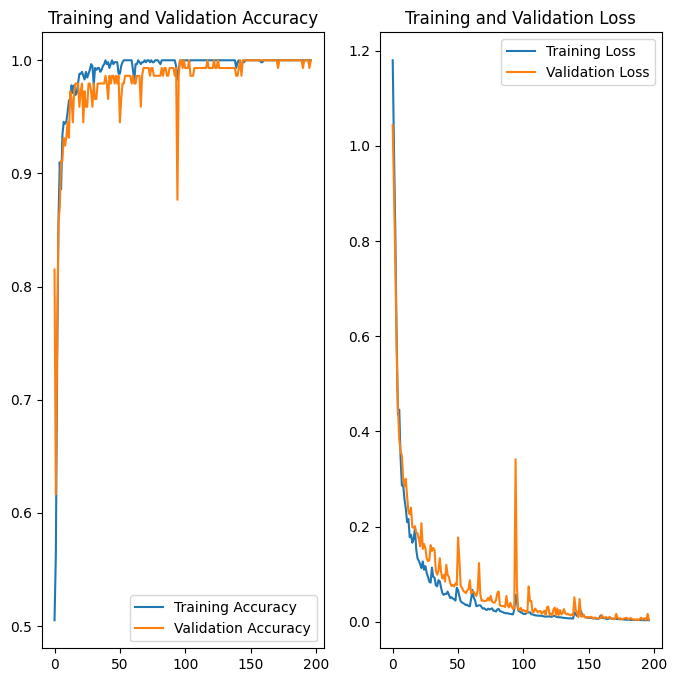

In [17]:
# Extraer métricas de precisión y pérdida del historial de entrenamiento
acc = history.history['accuracy']  # Precisión en el conjunto de entrenamiento
val_acc = history.history['val_accuracy']  # Precisión en el conjunto de validación

loss = history.history['loss']  # Pérdida en el conjunto de entrenamiento
val_loss = history.history['val_loss']  # Pérdida en el conjunto de validación

# Ajustar el rango de épocas para reflejar el número real de épocas entrenadas
epochs_range = range(len(acc))

# Configurar el tamaño de la figura para la visualización
plt.figure(figsize=(8, 8))

# Graficar la precisión de entrenamiento y validación
plt.subplot(1, 2, 1)  # Primer subplot en una figura de 1x2
plt.plot(epochs_range, acc, label='Training Accuracy')  # Precisión de entrenamiento
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Precisión de validación
plt.legend(loc='lower right')  # Posición de la leyenda
plt.title('Training and Validation Accuracy')  # Título del gráfico

# Graficar la pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)  # Segundo subplot en una figura de 1x2
plt.plot(epochs_range, loss, label='Training Loss')  # Pérdida de entrenamiento
plt.plot(epochs_range, val_loss, label='Validation Loss')  # Pérdida de validación
plt.legend(loc='upper right')  # Posición de la leyenda
plt.title('Training and Validation Loss')  # Título del gráfico

# Mostrar los gráficos
plt.show()

### Ahora se evaluarán las métricas del modelo usando el data_test

In [18]:
# Inicializar una lista vacía para almacenar las etiquetas de los archivos
lista_true = []

# Recorrer el directorio de documentos con contenido
for dirpath, dirnames, filenames in os.walk(test_true):
    # Para cada archivo en el directorio, agregar la etiqueta 'con_contenido' a la lista
    for file in filenames:
        lista_true.append(class_names[0])

# Recorrer el directorio de documentos sin contenido
for dirpath, dirnames, filenames in os.walk(test_false):
    # Para cada archivo en el directorio, agregar la etiqueta 'sin_contenido' a la lista
    for file in filenames:
        lista_true.append(class_names[1])

### Se llama de nuevo el tamaño de la imagen y se realizará la predicción en la data con_contenido y sin_contenido

In [19]:
# Inicializar una lista vacía para almacenar las predicciones
lista_predict = []

# Recorrer el directorio especificado para procesar los archivos
for dirpath, dirnames, filenames in os.walk(test_true):
    for file in filenames:
        # Construir la ruta absoluta al archivo
        file_path = os.path.abspath(os.path.join(dirpath, file))

        # Cargar la imagen, redimensionándola al tamaño objetivo
        img = tf.keras.utils.load_img(file_path, target_size=(img_width, img_width))
        # Convertir la imagen a un array
        img_array = tf.keras.utils.img_to_array(img)
        # Añadir una dimensión al array para cumplir con el formato de entrada del modelo
        img_array = tf.expand_dims(img_array, 0)
        
        # Realizar la predicción usando el modelo
        predictions = model.predict(img_array)
        # Aplicar la función softmax para obtener las probabilidades de las clases
        score = tf.nn.softmax(predictions[0])

        # Añadir la clase predicha a la lista, usando el nombre de la clase con la probabilidad más alta
        lista_predict.append(class_names[np.argmax(score)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━

In [20]:
# Recorrer el directorio especificado para procesar los archivos
for dirpath, dirnames, filenames in os.walk(test_false):
    for file in filenames:
        # Construir la ruta absoluta al archivo
        file_path = os.path.abspath(os.path.join(dirpath, file))

        # Cargar la imagen, redimensionándola al tamaño objetivo
        img = tf.keras.utils.load_img(file_path, target_size=(img_width, img_width))
        # Convertir la imagen a un array
        img_array = tf.keras.utils.img_to_array(img)
        # Añadir una dimensión al array para cumplir con el formato de entrada del modelo
        img_array = tf.expand_dims(img_array, 0)
        
        # Realizar la predicción usando el modelo
        predictions = model.predict(img_array)
        # Aplicar la función softmax para obtener las probabilidades de las clases
        score = tf.nn.softmax(predictions[0])

        # Añadir la clase predicha a la lista, usando el nombre de la clase con la probabilidad más alta
        lista_predict.append(class_names[np.argmax(score)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━

### Finalmente se calcula la precisón realizando una comparación uno a uno entre la lista con los valores verdaderos y los valores predecidos

In [21]:
def precision_modelo(lista_predict, lista_true):
    # Inicializar contador para el número de predicciones correctas
    cont = 0

    # Iterar a través de las listas de predicciones y verdaderas etiquetas
    for i in range(len(lista_predict)):
        # Comparar cada predicción con su correspondiente etiqueta verdadera
        if (lista_predict[i] == lista_true[i]):
            # Incrementar el contador si la predicción coincide con la etiqueta verdadera
            cont += 1
            
    # Calcular la precisión como el porcentaje de predicciones correctas sobre el total
    precision = (cont / len(lista_predict)) * 100

    # Devolver el valor de la precisión calculada
    return precision

In [22]:
# Calcular la precisión del modelo utilizando la función 'precision_modelo' con las listas de predicciones y etiquetas verdaderas
precision_model = precision_modelo(lista_predict, lista_true)

# Imprimir la precisión del modelo en el conjunto de prueba, formateada a dos decimales
print(f"La precisión del modelo en el conjunto de prueba es del {precision_model:.2f}%")

La precisión del modelo en el conjunto de prueba es del 99.00%


### Se calcula la matriz de confusión con la data_test

In [23]:
# Define una función para graficar la matriz de confusión
# y_true: etiquetas verdaderas
# y_pred: predicciones del modelo
# classes: lista de nombres de clases
# normalize: si se debe normalizar la matriz de confusión
# title: título del gráfico
# cmap: mapa de colores para el gráfico
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalizar la matriz de confusión si se especifica
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Mostrar la matriz de confusión como una imagen
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # Establecer el título del gráfico
    plt.title(title)
    # Añadir una barra de color para interpretar los valores
    plt.colorbar()
    # Establecer las marcas para los ejes x e y usando los nombres de las clases
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Establecer el formato de los números en la matriz de confusión
    fmt = '.2f' if normalize else 'd'
    # Calcular el umbral para cambiar el color del texto para mejor legibilidad
    thresh = cm.max() / 2.
    # Iterar sobre los elementos de la matriz de confusión para añadirlos al gráfico
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="black")

    # Ajustar el layout para evitar recortes
    plt.tight_layout()
    # Establecer las etiquetas de los ejes
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Predicción del modelo')
    # Mostrar el gráfico
    plt.show()

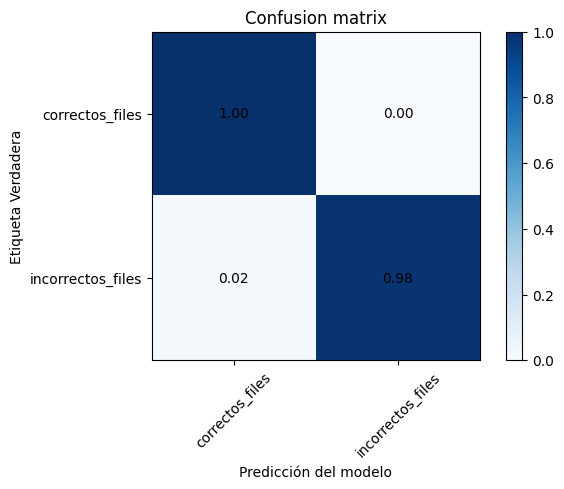

In [24]:
# Graficar la matriz de confusión utilizando las etiquetas verdaderas y las predicciones del modelo
plot_confusion_matrix(lista_true, lista_predict, class_names, normalize=True, title='Confusion matrix')

### Para terminar extraer el f1_score

In [25]:
# Calcular el F1 Score, que es una medida de la precisión del modelo teniendo en cuenta tanto la precisión como la sensibilidad/recall
f1 = f1_score(lista_true, lista_predict, labels=class_names, average='weighted')

# Imprimir el F1 Score redondeado a dos decimales
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.99


### Lo último que faltaría es reutilizar este modelo para extraer aún más imágenes sin contenido y amplizar la base, con mas data el modelo quedaría aún mas robusto y generalizable, se probó con data externa no vista de otro tema totalmente diferente y el modelo se desempeñó bien con una precisión superior al 98%. Adicionalmente se debería realizar un grid search, y como cada vez que se corre el modelo cambia se debería guardar cada modelo y comparar los resultados del viejo modelo contra el nuevo, si el nuevo mejoró reescribir el modelo hasta encontrar un mejor modelo.

In [26]:
# shutil.rmtree("data_test")
# shutil.rmtree("data_aumentada_datasets")

swish

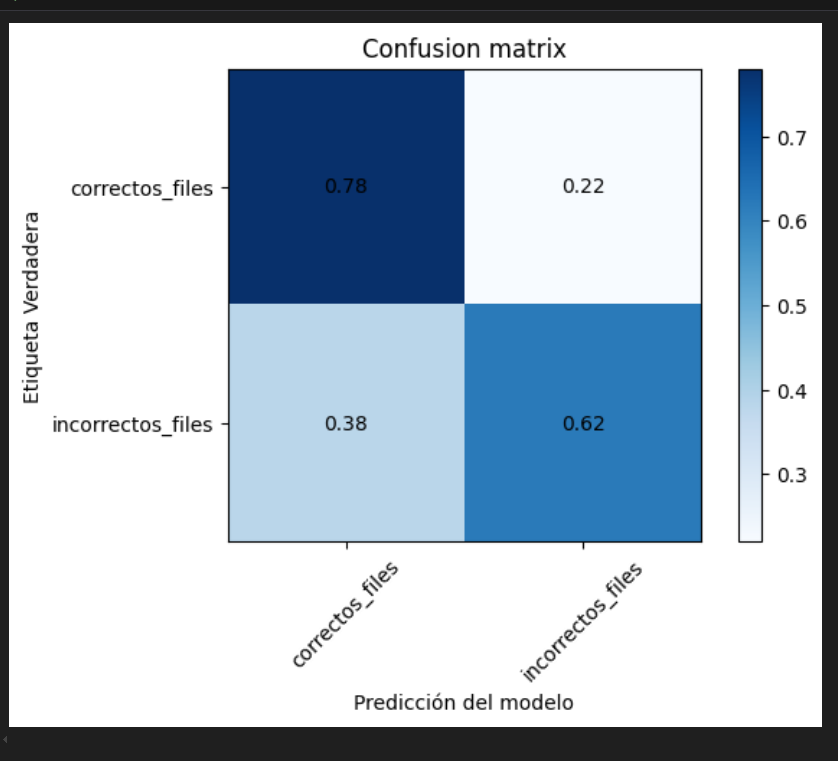

elu

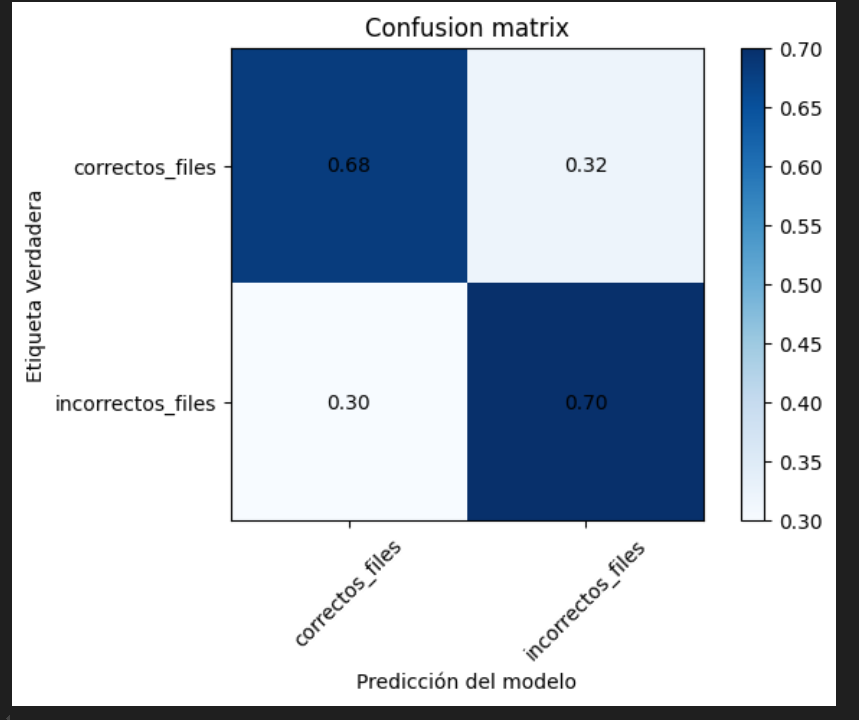

sigmoid

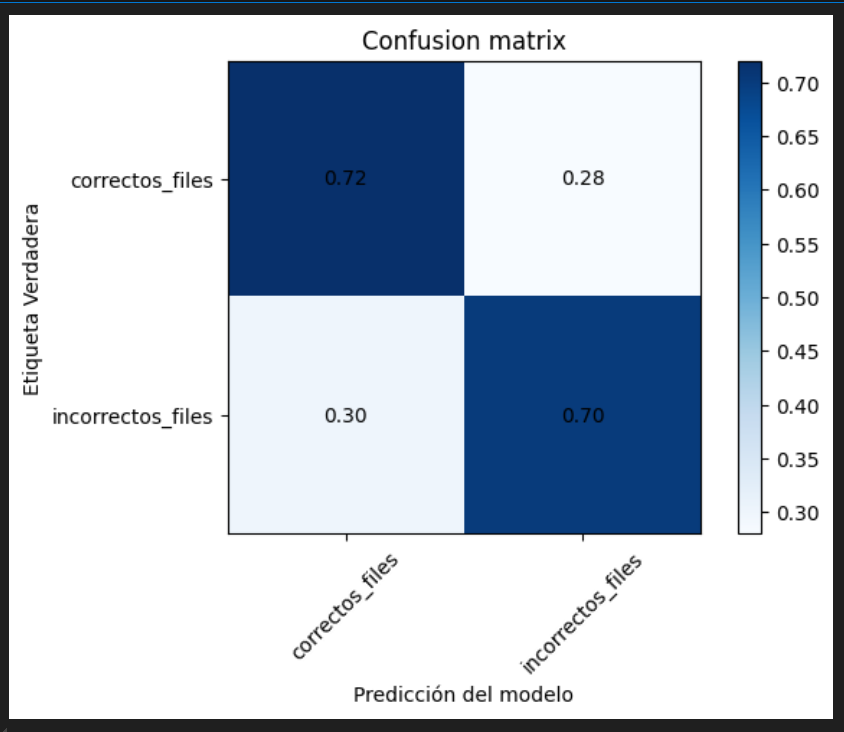

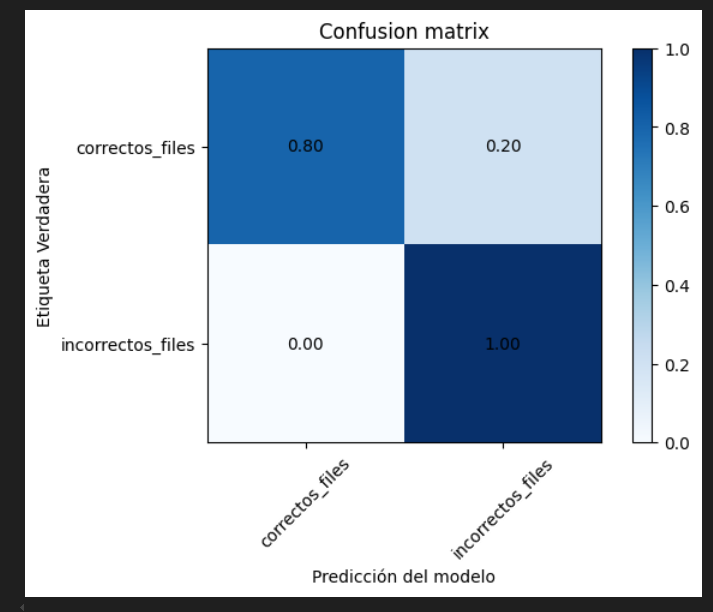

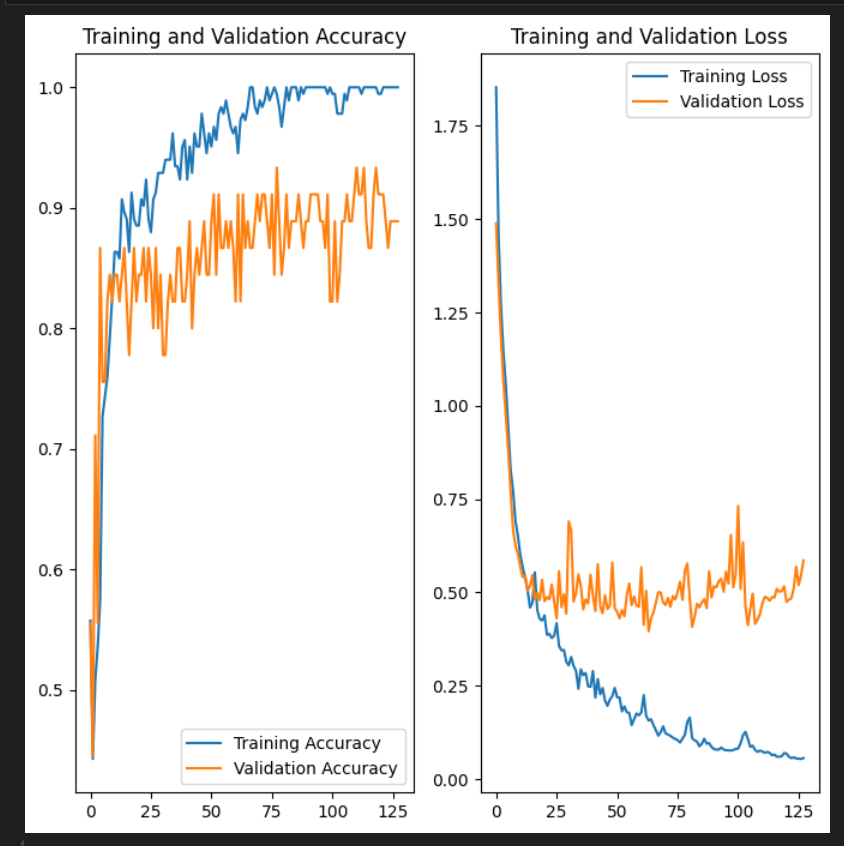